In [1]:
import pandas as pd # algebraic computations , read and write to csv 

import numpy as np # linear algebra and arrays muniplication 

import requests, zipfile, io    # Needed to download and extract the data sets of dev and eval 

# from pandarallel import pandarallel       # Parallel computation on data frames
import time                               # measure excution time of some functions

############  importing the data visualization libraries :##############

import matplotlib.pyplot as plt
import seaborn as sns

############  Import Classifiers #################

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import BernoulliNB

# Importing a model to split the training set from the evaluation set
from sklearn.model_selection import train_test_split 

############  Evaluation Metric  #################
from sklearn.metrics import f1_score , make_scorer

############  GridSearchCV #################
from sklearn.model_selection import GridSearchCV

################## Tuxtual data prprocessing ##################
from sklearn. feature_extraction.text import TfidfVectorizer 
import warnings
warnings.filterwarnings("ignore")
from os import path
from PIL import Image
#
import nltk
from wordcloud import WordCloud
from nltk import pos_tag
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer ,word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as sw
import re
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
#### some libraries must be downloaded
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('pos_tag')
nltk.download('averaged_perceptron_tagger') 

%matplotlib inline
plt.style.use('seaborn-notebook' ) # plotting style

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\musta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\musta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading pos_tag: Package 'pos_tag' not found in
[nltk_data]     index
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\musta\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### download and extract the data sets and make data frames for development and evaluation 

In [2]:
def download_dataset(zip_file_url):
    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
    
download_dataset('https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip')



In [3]:
dev_df = pd.read_csv('./DSL2122_january_dataset/development.csv')    
eval_df = pd.read_csv('./DSL2122_january_dataset/evaluation.csv')

## Duplicates Removal

In [4]:
# Since we have no background of which tweet has the priority (The 2 tweets are identical in every feature values and not in the class label) and since the duplicated raws are only 0.25% of the whole dataset we decided to discard them 
def Remove_duplicated (df) :
    x = list(df.drop(["sentiment"] , axis=1).columns)
    df_drop_duplicates = df.copy(deep=True)
    df_drop_duplicates.drop_duplicates(subset = x ,keep=False , inplace = True )
    print("*" * 50 ,"\n" ,f"len data set before remove duplication is  {len(df)} samples")
    print("*" * 50 ,"\n" ,f"The ratio of duplicated samples in the data set is  {100*(len(df) -len(df_drop_duplicates))/len(df) :0.3f} %")
    print("*" * 50 ,"\n" ,f"len data set after remove duplication is  {len(df_drop_duplicates)} samples")
    return df_drop_duplicates

In [5]:
df_drop_duplicates = Remove_duplicated(dev_df)

************************************************** 
 len data set before remove duplication is  224994 samples
************************************************** 
 The ratio of duplicated samples in the data set is  0.247 %
************************************************** 
 len data set after remove duplication is  224438 samples


# Textual Feature sentamint analysis

####  Analyzing user Feature 

In [6]:
# We will make a copy for data exploration so we don't change the oriniginal data frame 
df_explor = df_drop_duplicates.copy(deep=True)

In [7]:
print(f" the cardinality of the user feature is {df_explor.user.nunique()}")

 the cardinality of the user feature is 10647


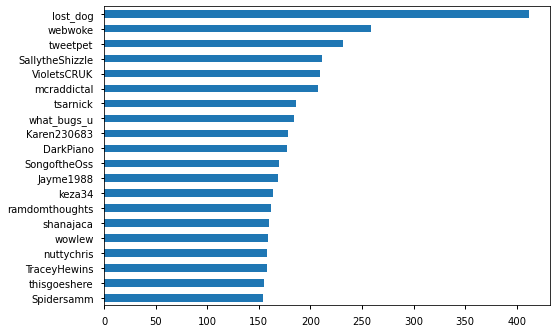

In [8]:
# plot the users with 20 highest number of reviews 
df_explor["user"].value_counts()[:20].sort_values(ascending=True).plot.barh()
plt.savefig("top 20 frequent tweet users ")
plt.show()

##### splitting the Data to positive and Negative sentiments

In [9]:
df_positive = df_explor[df_explor['sentiment'] == 1]
df_neg = df_explor[df_explor['sentiment'] == 0]

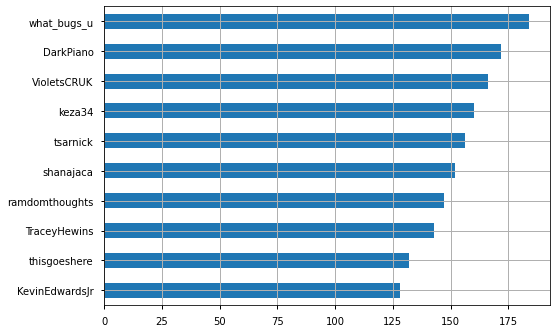

In [10]:
# Positive users 
df_positive['user'].value_counts().nlargest(10).sort_values(ascending = True).plot.barh()
plt.grid()

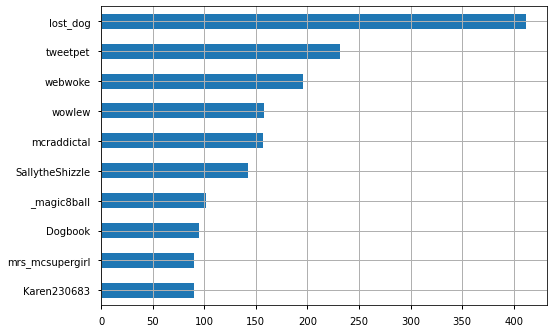

In [11]:
# negative users 
df_neg['user'].value_counts().nlargest(10).sort_values(ascending = True).plot.barh()

plt.grid()

#### some examples of how some "users" are discriminitive an can be useful for analysis

In [12]:
# Negative user
mask = df_explor['user']  == 'lost_dog' 
df_explor.loc[mask , ['sentiment']].value_counts()

sentiment
0            412
dtype: int64

In [13]:
# Positive user
mask = df_explor['user']  == 'what_bugs_u' 
df_explor.loc[mask , ['sentiment']].value_counts()

sentiment
1            184
dtype: int64

In [14]:
df_explor['user'] = df_explor['user'].astype("string")

#### Analyzing Hashtags

In [15]:
def extract_hashtags(document) :
    ht = re.findall(r'#(\w+)' , document)
    if len(ht) > 0:
        hashtags = ' '.join([w.strip().lower() for w in ht ])
    else :
        hashtags = np.nan
    return hashtags 

In [16]:
df_explor['hashtags'] = df_explor['text'].apply(lambda text : extract_hashtags(text) )

In [17]:
pd.set_option("display.max_rows" , 300)
df_explor['hashtags'][df_explor['hashtags'].notna()]

40                jonaskevin
85              clothdiapers
143                wolverine
144       tobaccochewingdick
164               myweakness
                 ...        
224835                  nola
224851            apprentice
224856           musicmonday
224887                    ff
224920                    ff
Name: hashtags, Length: 6478, dtype: object

In [18]:
# just for exploration we replace the samples that don't contain hashtags with 'nohashtag'
df_explor.hashtags.fillna(value = 'nohashtag',inplace=True)

In [19]:
all_hashtags = list(set(df_explor['hashtags']))

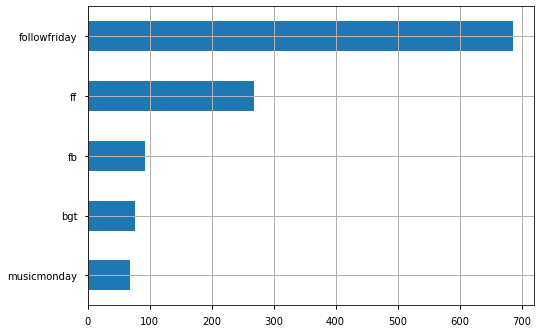

In [20]:
# All Hashtags 
df_explor['hashtags'][df_explor['hashtags'] != 'nohashtag'].value_counts().nlargest(5).sort_values(ascending = True).plot.barh()
plt.grid()
# plt.xticks(rotation=45)

In [21]:
df_positive = df_explor[df_explor['sentiment'] == 1]
df_neg = df_explor[df_explor['sentiment'] == 0]

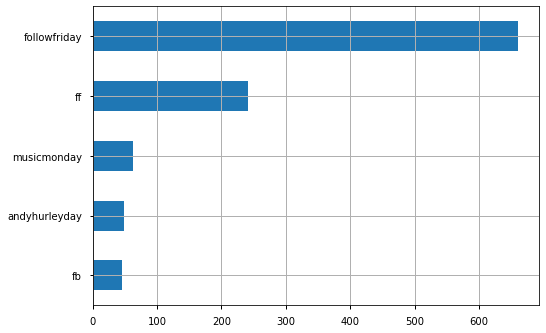

In [22]:
# Positive hashtags 
df_positive['hashtags'][df_positive['hashtags'] != 'nohashtag'].value_counts().nlargest(5).sort_values(ascending = True).plot.barh()
plt.grid()


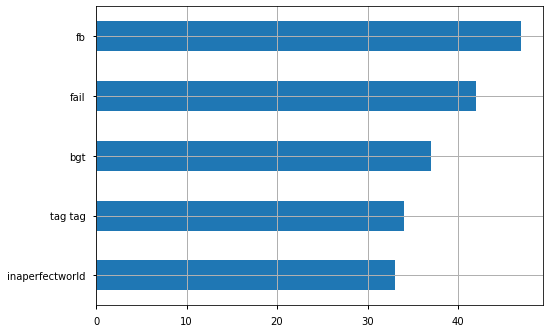

In [23]:
# negative hashtags 
df_neg['hashtags'][df_neg['hashtags'] != 'nohashtag'].value_counts().nlargest(5).sort_values(ascending = True).plot.barh()
plt.grid()


#### some examples of how some "Hashtags" are discriminitive an can be useful for analysis

In [24]:
mask = df_explor['hashtags']  == 'followfriday' 
df_explor.loc[mask , ['sentiment']].value_counts()

sentiment
1            660
0             26
dtype: int64

In [25]:
mask = df_explor['hashtags']  == 'ff' 
df_explor.loc[mask , ['sentiment']].value_counts()

sentiment
1            241
0             28
dtype: int64

In [26]:
mask = df_explor['hashtags']  == 'fail' 
df_explor.loc[mask , ['sentiment']].value_counts()

sentiment
0            42
1            10
dtype: int64

In [27]:
mask = df_explor['hashtags']  == 'idiot' 
df_explor.loc[mask , ['sentiment']].value_counts()

sentiment
1            20
dtype: int64

In [28]:
df_explor['user'] = df_explor["user"].apply(lambda text :  "user" +str(text).strip())
df_explor['text'] = df_explor['text'] + df_explor["user"]